#### Loading

In [10]:
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np 
from PIL import Image
import torch
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

def read_and_transform_images(folder_path):
    """Reads images from a folder and applies a transformation."""

    transformed_images = []
    for filename in os.listdir(folder_path):
        if filename.endswith((".jpg", ".JPG", ".BMP",".jpeg", ".png")):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)

            # Apply transformation here (e.g., resize)
            img = img.resize((256, 256))
            img = img.convert("L") 
            # Convert to numpy array if needed
            img_array = np.array(img)
            
            transformed_images.append(img_array)

    return transformed_images

image_dir='/Users/amir.taqieddin/Desktop/Hackathon/X-ray-PBD-main/x_ray_pbd_datasets/train/img'
images_org = read_and_transform_images(image_dir)
image_dir='/Users/amir.taqieddin/Desktop/Hackathon/X-ray-PBD-main/train_crop_data/img_crop'
images_crop = read_and_transform_images(image_dir)

image_dir='/Users/amir.taqieddin/Desktop/Hackathon/X-ray-PBD-main/x_ray_pbd_datasets/test/img'
images_org2 = read_and_transform_images(image_dir)


class ImageDataset(Dataset):
    def __init__(self, images_org, images_crop):
        self.images_org = images_org
        self.images_crop = images_crop
        self.transform = transforms.Compose([
            transforms.ToTensor(),  # Convert numpy array to PyTorch tensor
            transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale image
        ])
        
    def __len__(self):
        return len(self.images_org)
    
    def __getitem__(self, idx):
        image_org = self.images_org[idx]
        image_crop = self.images_crop[idx]
        
        # Apply transformation to both images
        image_org = self.transform(image_org)
        image_crop = self.transform(image_crop)
        
        # Ensure both images are on the correct device
        return image_org.to(device), image_crop.to(device)
    

# Assuming images_org and images_crop are defined somewhere else
# Create Dataset with paired input and target
train_dataset = ImageDataset(images_org, images_crop)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Example of iterating over the DataLoader
for input_image, target_image in train_dataloader:
    print(f"Input batch shape: {input_image.shape}")   # [batch_size, 1, 224, 224]
    print(f"Target batch shape: {target_image.shape}") # [batch_size, 1, 224, 224]
    break  # Just show one batch for demonstration

Input batch shape: torch.Size([4, 1, 256, 256])
Target batch shape: torch.Size([4, 1, 256, 256])


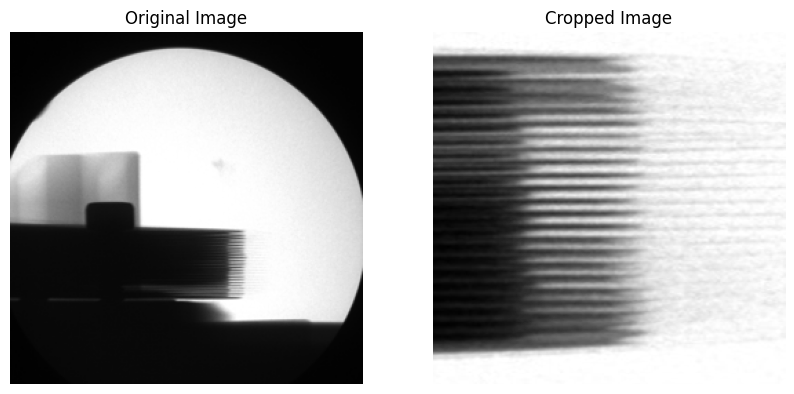

In [73]:
import random

# Function to visualize an original image and its corresponding cropped image
def view_random_image(dataset):
    # Randomly select an index
    idx = random.randint(0, len(dataset) - 1)
    
    # Retrieve the image pair
    image_org, image_crop = dataset[idx]
    
    # Reverse normalization for visualization
    image_org = image_org.cpu().numpy().squeeze() * 0.5 + 0.5  # Denormalize
    image_crop = image_crop.cpu().numpy().squeeze() * 0.5 + 0.5  # Denormalize
    # Plot the images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image_org, cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    axes[1].imshow(image_crop, cmap='gray')
    axes[1].set_title("Cropped Image")
    axes[1].axis("off")
    
    plt.show()
    return image_org

# Call the function to view a random pair
image_crop=view_random_image(train_dataset)

In [74]:
from scipy import ndimage as ndi
from skimage.filters import sobel
from skimage.segmentation import watershed
class Find_Watershed(object):
    def __init__(self, fig, ax1, ax2, ax3, img_input, mask=None):
        self.image = img_input
        self.mask = mask
        self.initial_blur = 3
        self.image_blurred = self._preprocess_image(self.image, self.initial_blur)

        self.lower_threshold = 80
        self.upper_threshold = 250
        self.expand_iterations = 1

        self.markers = np.zeros_like(self.image_blurred)
        self._initialize_markers()

        self.segmentation = watershed(self.elevation_map, self.markers)
        self.segmentation = ndi.binary_fill_holes(self.segmentation - 1)
        self._refine_segmentation()

        self._display_results(ax1, ax2, ax3)
        self._setup_sliders_and_buttons()
        self._calculate_coordinates()

    def _preprocess_image(self, image, blur):
        """Apply preprocessing: adaptive histogram equalization and Gaussian blur."""
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        equalized = clahe.apply(image)
        blurred = ndi.gaussian_filter(equalized, blur)
        self.elevation_map = sobel(blurred)
        return blurred

    def _initialize_markers(self):
        """Initialize markers for watershed segmentation."""
        self.markers[self.image_blurred < self.lower_threshold] = 1
        self.markers[self.image_blurred > self.upper_threshold] = 2
        if self.mask is not None:
            self.markers[self.mask] = 1

    def _refine_segmentation(self):
        """Refine segmentation using edge detection and morphology."""
        # Remove small objects
        self.segmentation = morphology.remove_small_objects(self.segmentation, min_size=1500)

        # Detect edges and refine boundaries
        edges = canny(self.image_blurred, sigma=1.5)
        self.segmentation = morphology.binary_closing(self.segmentation, morphology.disk(3))
        self.segmentation = np.logical_or(self.segmentation, edges)
        self.segmentation = ndi.binary_fill_holes(self.segmentation)

    def _display_results(self, ax1, ax2, ax3):
        """Display initial results in the axes provided."""
        ax1.imshow(self.image_blurred, cmap='gray')
        ax1.set_title('Preprocessed Image', fontsize=20)

        image_pixels = np.array(self.image)
        kernel = np.ones((3, 3), np.uint8)
        dilated_mask = cv2.dilate(self.segmentation.astype(np.uint8), kernel, iterations=self.expand_iterations)
        self.segmentation = dilated_mask.astype(bool)
        image_pixels[self.segmentation] = 0
        self.output_image = Image.fromarray(image_pixels)

        ax2.imshow(self.image_blurred, cmap='gray')
        ax2.imshow(self.segmentation, cmap='cool', alpha=0.3)
        ax2.set_title('Overlay', fontsize=20)

        ax3.imshow(self.output_image, cmap='gray')
        ax3.set_title('Refined Result', fontsize=20)

        for a in [ax1, ax2, ax3]:
            a.axis('off')

    def _setup_sliders_and_buttons(self):
        """Setup sliders and buttons for interactive adjustment."""
        self.ax_blur = plt.axes([0.25, 0.2, 0.65, 0.03])
        self.ax_upper = plt.axes([0.25, 0.15, 0.65, 0.03])
        self.ax_lower = plt.axes([0.25, 0.1, 0.65, 0.03])
        self.ax_expand = plt.axes([0.25, 0.05, 0.65, 0.03])
        self.blur = Slider(self.ax_blur, 'Blur', 0, 10, valinit=self.initial_blur)
        self.upper = Slider(self.ax_upper, 'Upper Cutoff', 0, 255, valinit=self.upper_threshold)
        self.lower = Slider(self.ax_lower, 'Lower Cutoff', 0, 255, valinit=self.lower_threshold)
        self.expand = Slider(self.ax_expand, 'Expand Selection', 0, 10, valinit=1, valstep=1, valfmt='%0.0f')

        self.blur.on_changed(self.update)
        self.upper.on_changed(self.update)
        self.lower.on_changed(self.update)
        self.expand.on_changed(self.update)

        self.resetax = plt.axes([0.8, 0.01, 0.1, 0.04])
        self.confirmax = plt.axes([0.9, 0.01, 0.1, 0.04])

        self.button_reset = Button(self.resetax, 'Reset', color='gold', hovercolor='skyblue')
        self.button_confirm = Button(self.confirmax, 'Confirm', color='blue', hovercolor='skyblue')
        self.button_reset.on_clicked(self.resetSlider)
        self.button_confirm.on_clicked(self.confirm)

    def _calculate_coordinates(self):
        """Store the coordinates of segmented regions."""
        transposed_segmentation = self.segmentation.transpose()
        width, height = np.shape(transposed_segmentation)
        self.coordinates = [[x, y] for x in range(width) for y in range(height)
                            if transposed_segmentation[x, y]]

    def update(self, val):
        self.image_blurred = self._preprocess_image(self.image, self.blur.val)
        self.lower_threshold = self.lower.val
        self.upper_threshold = self.upper.val
        self.expand_iterations = self.expand.val

        self._initialize_markers()
        self.segmentation = watershed(self.elevation_map, self.markers)
        self.segmentation = ndi.binary_fill_holes(self.segmentation - 1)
        self._refine_segmentation()
        self._display_results(ax1, ax2, ax3)
        self._calculate_coordinates()
        fig.canvas.draw_idle()

    def resetSlider(self, event):
        self.blur.reset()
        self.lower.reset()
        self.upper.reset()
        self.expand.reset()

    def confirm(self, event):
        plt.close()


In [75]:
def converter(img, mask):
    if isinstance(img, Image.Image):
        img_array = np.array(img)  # Convert to NumPy array
    else:
        img_array = np.uint8(np.array(img))

    # Ensure mask shape matches image
    if mask.shape != img_array.shape:
        raise ValueError("Mask and image dimensions do not match.")

    # Apply the mask (set masked regions to black)
    img_array[mask] = 0

    # Convert back to PIL Image
    new_img = Image.fromarray(img_array)
    return new_img

In [76]:
from matplotlib.patches import Polygon
from matplotlib.patches import Polygon
from skimage import filters, morphology, measure, exposure

class AnnotateAutomatic:
    def __init__(self, fig, ax, img):
        self.fig = fig
        self.ax = ax
        self.img = img
        self.vertices = []
        self.poly = None
        self.finished = False
        self.LL = None
        self.UL = None
        self.LR = None
        self.UR = None
        self.poly_mask_2d = None  # Initialize the 2D polygon mask
        self.bbox = None  # Bounding box for zoom

    def auto_detect_roi(self):
        """
        Automatically detect the electrode region using edge detection and thresholding.
        """
        # Apply histogram equalization to enhance edges
        enhanced_img = exposure.equalize_adapthist(self.img, clip_limit=0.03)

        # Use Otsu thresholding to binarize the image
        threshold_value = filters.threshold_otsu(enhanced_img)
        binary_mask = enhanced_img < threshold_value  # Focus on darker electrode regions

        # Clean up the binary mask
        cleaned_mask = morphology.remove_small_objects(binary_mask, min_size=500)
        cleaned_mask = morphology.binary_closing(cleaned_mask, morphology.disk(5))

        # Identify the largest connected component as the electrode region
        label_img = measure.label(cleaned_mask)
        regions = measure.regionprops(label_img)
        if not regions:
            raise ValueError("No ROI detected in the image.")

        largest_region = max(regions, key=lambda r: r.area)

        # Determine bounding box of the electrode region
        min_row, min_col, max_row, max_col = largest_region.bbox
        self.bbox = (min_row, min_col, max_row, max_col)  # Store bounding box
        self.LL = (min_col, max_row)
        self.UL = (min_col, min_row)
        self.LR = (max_col, max_row)
        self.UR = (max_col, min_row)

        # Define the vertices of the polygon ROI
        self.vertices = [self.LL, self.UL, self.UR, self.LR]

        # Generate the polygon mask
        self._generate_polygon_mask()

    def _generate_polygon_mask(self):
        """
        Generate a binary mask (poly_mask_2d) for the ROI defined by the vertices.
        """
        x_coords, y_coords = np.meshgrid(np.arange(self.img.shape[1]), np.arange(self.img.shape[0]))
        all_points = np.column_stack((x_coords.ravel(), y_coords.ravel()))
        poly_path = Polygon(self.vertices).get_path()
        poly_mask = poly_path.contains_points(all_points).reshape(self.img.shape)
        self.poly_mask_2d = poly_mask

    def draw_roi(self):
        """
        Draw the automatically detected ROI on the image with zooming around the region.
        """
        if not self.vertices:
            raise RuntimeError("No ROI defined. Run 'auto_detect_roi' first.")

        # Zoom into the bounding box
        min_row, min_col, max_row, max_col = self.bbox
        self.ax.set_xlim(min_col, max_col)
        self.ax.set_ylim(max_row, min_row)  # Inverted y-axis

        # Draw the polygon
        self.poly = Polygon(self.vertices, lw=3, edgecolor='cyan', facecolor='none')
        self.ax.add_patch(self.poly)
        self.ax.imshow(self.img, cmap='gray')
        self.ax.set_title("Highlighted Electrode Region (Zoomed)")
        self.ax.axis('off')
        self.fig.canvas.draw()
        self.finished = True

    def get_roi_data(self):
        """
        Extract data from the ROI as a masked image.
        """
        if self.poly_mask_2d is None:
            raise RuntimeError("No ROI mask defined. Run 'auto_detect_roi' first.")

        # Apply the mask to the image
        roi_data = np.copy(self.img)
        roi_data[~self.poly_mask_2d] = 0
        return roi_data


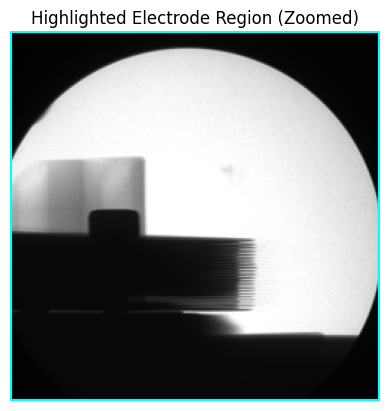

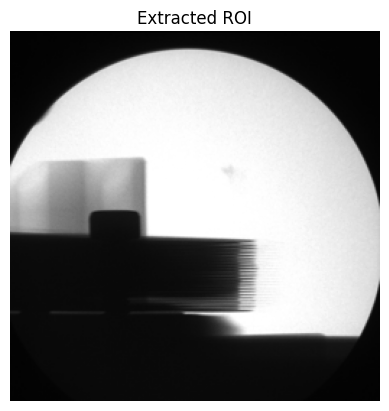

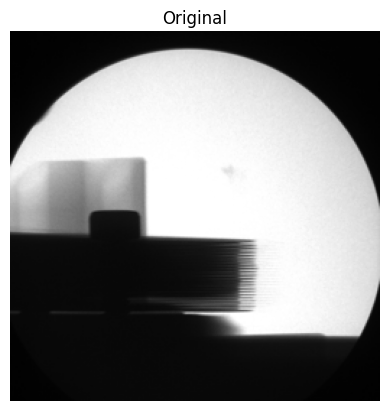

In [77]:
fig, ax = plt.subplots()
height, width = image_crop.shape  # Get height and width of the image

a = AnnotateAutomatic(fig, ax, image_crop)

    
    # Automatically detect the ROI and display it
a.auto_detect_roi()
a.draw_roi()

# Extract ROI data
roi_data = a.get_roi_data()
plt.figure()
plt.imshow(roi_data, cmap='gray')
plt.title("Extracted ROI")
plt.axis('off')
plt.show()

plt.figure()
plt.imshow(image_crop, cmap='gray')
plt.title("Original")
plt.axis('off')
plt.show()


In [71]:
# Convert the original image using the inverted mask
img = converter(image_crop, ~a.poly_mask_2d).copy()
pixvals = np.array(img)  # Convert the image to a NumPy array
pixvals_masked = pixvals[a.poly_mask_2d]  # Get values inside the mask

# Parameters
segments = 1
y_range = int(a.UL[1] - a.LL[1])

# Process the image in segments
for i in range(segments):
    # Determine the slice range for the current segment
    begin = int(y_range / segments) * i + int(a.LL[1])
    end = int(y_range / segments) * (i + 1) + int(a.LL[1])

    # Ensure segment bounds are within the image
    begin = max(0, begin)
    end = min(pixvals.shape[0], end)

    # Slice the mask and pixel values for the current segment
    poly_sub_mask = a.poly_mask_2d[begin:end, :]
    sub_pixvals = pixvals[begin:end, :]  # Corresponding pixel values
    black_sub_mask = sub_pixvals != 0  # Ensure non-zero values

    # Combine masks: pixels within the polygon mask and non-zero
    combined_mask = np.bitwise_and(poly_sub_mask, black_sub_mask)

    # Apply percentile-based normalization only if there are valid pixels
    sub_mask = sub_pixvals[combined_mask]
    if sub_mask.size > 0 and np.max(sub_mask) > 0:
        minval = np.percentile(sub_mask, 10)
        maxval = np.percentile(sub_mask, 90)

        # Avoid division by zero
        if maxval > minval:
            # Create a temporary normalized segment
            normalized_segment = np.clip(sub_pixvals, minval, maxval)
            normalized_segment = ((normalized_segment - minval) / (maxval - minval)) * 255

            # Update only the valid mask regions in the original array
            pixvals[begin:end, :][combined_mask] = normalized_segment[combined_mask]

# Ensure final pixel values are within valid range
pixvals = np.clip(pixvals, 0, 255).astype(np.uint8)
# Convert back to PIL image
img_res = Image.fromarray(pixvals.astype(np.uint8))

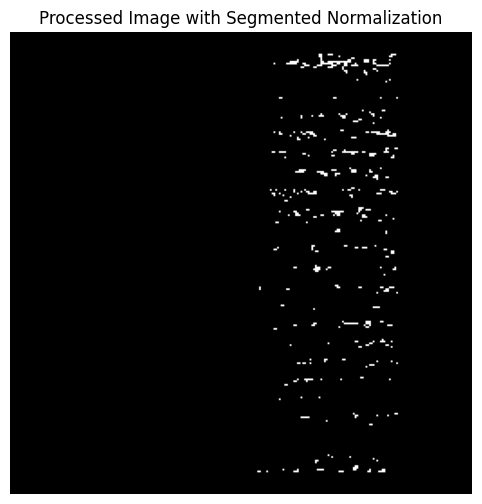

In [72]:
plt.figure(figsize=(8, 6))
plt.imshow(img_res, cmap='gray')
plt.title("Processed Image with Segmented Normalization")
plt.axis("off")
plt.show()

In [68]:
left = a.LL[0]
right = a.UR[0]
bottom = a.LL[1]
top = a.UR[1]
img_res_mask = Image.fromarray(a.poly_mask_2d)
img_res_mask = img_res_mask.crop((left,bottom,right,top))
img_res = img_res.crop((left,bottom,right,top))
img_original = image_crop.crop((left, bottom, right, top))

ValueError: Coordinate 'lower' is less than 'upper'

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import convolution

from KANLinear import KANLinear

from KANConv import KAN_Convolutional_Layer

class AttentionModule(nn.Module):
    def __init__(self, in_channels, attention_channels):
        super(AttentionModule, self).__init__()
        self.attention_conv = nn.Conv2d(in_channels, attention_channels, kernel_size=3, padding=1)
        self.attention_fc = nn.Conv2d(attention_channels, 1, kernel_size=1)

    def forward(self, x):
        attention_map = self.attention_conv(x)
        attention_map = F.relu(attention_map)
        attention_map = self.attention_fc(attention_map)
        attention_map = torch.sigmoid(attention_map)
        return attention_map

class KKAN_Small(nn.Module):
    def __init__(self, grid_size: int = 5):
        super().__init__()
        self.conv1 = KAN_Convolutional_Layer(in_channels=1,
            out_channels= 5,
            kernel_size= (3,3),
            grid_size = grid_size,
            padding =(0,0)
        )

        self.conv2 = KAN_Convolutional_Layer(in_channels=5,
            out_channels= 5,
            kernel_size = (3,3),
            grid_size = grid_size,
            padding =(0,0)
        )

        self.pool1 = nn.MaxPool2d(
            kernel_size=(2, 2)
        )
        
        self.flat = nn.Flatten() 

        self.kan1 = KANLinear(
            125,
            10,
            grid_size=grid_size,
            spline_order=3,
            scale_noise=0.01,
            scale_base=1,
            scale_spline=1,
            base_activation=nn.SiLU,
            grid_eps=0.02,
            grid_range=[0,1],
        )
        self.name = f"KKAN (Small) (gs = {grid_size})"


    def forward(self, x):
        x = self.conv1(x)

        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool1(x)
        x = self.flat(x)
        x = self.kan1(x) 
        x = F.log_softmax(x, dim=1)

        return x

class KKAN_Convolutional_Network(nn.Module):
    def __init__(self, grid_size: int = 5):
        super().__init__()
        self.conv1 = KAN_Convolutional_Layer(
            in_channels=1,
            out_channels= 5,
            kernel_size= (3,3),
            grid_size = grid_size,
            padding =(0,0)
        )

        self.conv2 = KAN_Convolutional_Layer(in_channels=5,
            out_channels= 10,
            kernel_size = (3,3),
            grid_size = grid_size,
            padding =(0,0)

        )

        self.pool1 = nn.MaxPool2d(
            kernel_size=(2, 2)
        )
        
        self.flat = nn.Flatten() 

        self.kan1 = KANLinear(
            250,
            10,
            grid_size=grid_size,
            spline_order=3,
            scale_noise=0.01,
            scale_base=1,
            scale_spline=1,
            base_activation=nn.SiLU,
            grid_eps=0.02,
            grid_range=[0,1],
        )
        self.name = f"KKAN (Medium) (gs = {grid_size})"


    def forward(self, x):
        x = self.conv1(x)

        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool1(x)
        x = self.flat(x)
        x = self.kan1(x) 
        x = F.log_softmax(x, dim=1)

        return x

class CNNWithAttention(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(CNNWithAttention, self).__init__()
        
        # Encoder part (downsampling)
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Downsample
        
        # Attention mechanism (optional)
        self.attention = AttentionModule(256, 128)
        
        # Decoder part (upsampling)
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, out_channels, kernel_size=3, padding=1)
        
        # Optional: Ensure final output size is the same as target size
        self.final_conv = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        # Encoder part
        x1 = F.relu(self.conv1(x))
        x2 = self.pool(F.relu(self.conv2(x1)))
        x3 = self.pool(F.relu(self.conv3(x2)))
        
        # Attention mechanism
        attention_map = self.attention(x3)
        x3 = x3 * attention_map  # Apply attention to the feature map
        
        # Decoder part (upsampling)
        x4 = F.relu(self.deconv1(x3))
        x5 = F.relu(self.deconv2(x4))
        output = self.deconv3(x5)
        output = F.interpolate(output, size=(256, 256), mode='bilinear', align_corners=False)

        # Ensure output is same size as input (256x256)
        output = self.final_conv(output)  # Optional: use final convolution to fine-tune output size
        
        return output


class attention2D(nn.Module):
    """
    Attention mechanism for 2D dynamic convolution.
    """
    def __init__(self, in_channels, ratio=0.25, num_kernels=4, temperature=34, init_weight=True):
        super(attention2D, self).__init__()
        assert temperature % 3 == 1, "Temperature must satisfy `temperature % 3 == 1`."
        
        self.temperature = temperature
        hidden_channels = max(int(in_channels * ratio), 1)

        # Attention layers
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, hidden_channels, kernel_size=1, bias=False)
        self.fc2 = nn.Conv2d(hidden_channels, num_kernels, kernel_size=1, bias=True)

        # Initialize weights
        if init_weight:
            self._initialize_weights()

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight, mode="fan_out", nonlinearity="relu")
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

    def update_temperature(self):
        """Reduce the temperature to sharpen the attention distribution."""
        if self.temperature > 1:
            self.temperature -= 3
            print(f"Updated temperature: {self.temperature}")

    def forward(self, x):
        # Global context extraction
        context = self.global_pool(x)
        
        # Fully connected layers
        attention = F.relu(self.fc1(context))
        attention = self.fc2(attention).view(x.size(0), -1)  # (Batch, num_kernels)

        # Normalize with softmax and temperature scaling
        return F.softmax(attention / self.temperature, dim=1)


class cnn2D(nn.Module):
    """
    Dynamic 2D Convolution with attention-based kernel selection.
    """
    def __init__(self, in_channels, out_channels, kernel_size, ratio=0.25, stride=1, padding=0, dilation=1, groups=1, bias=True, num_kernels=4, temperature=34, init_weight=True):
        super(cnn2D, self).__init__()
        assert in_channels % groups == 0, "Input channels must be divisible by groups."
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = groups
        self.num_kernels = num_kernels

        # Attention mechanism
        self.attention = attention2D(in_channels, ratio, num_kernels, temperature)

        # Kernel weights and bias
        self.weight = nn.Parameter(
            torch.randn(num_kernels, out_channels, in_channels // groups, kernel_size, kernel_size), 
            requires_grad=True
        )
        self.bias = nn.Parameter(torch.zeros(num_kernels, out_channels)) if bias else None

        # Initialize weights
        if init_weight:
            self._initialize_weights()

    def _initialize_weights(self):
        for i in range(self.num_kernels):
            nn.init.kaiming_uniform_(self.weight[i])
        if self.bias is not None:
            nn.init.constant_(self.bias, 0)

    def update_temperature(self):
        """Update the temperature in the attention mechanism."""
        self.attention.update_temperature()

    def forward(self, x):
        batch_size, _, height, width = x.size()

        # Compute attention weights
        attention_weights = self.attention(x)  # (Batch, num_kernels)

        # Flatten kernel weights for dynamic aggregation
        weight_flat = self.weight.view(self.num_kernels, -1)  # (num_kernels, out_channels * in_channels // groups * kernel_size^2)

        # Dynamically aggregate weights and bias
        aggregated_weight = torch.matmul(attention_weights, weight_flat).view(
            batch_size * self.out_channels, 
            self.in_channels // self.groups, 
            self.kernel_size, 
            self.kernel_size
        )
        if self.bias is not None:
            aggregated_bias = torch.matmul(attention_weights, self.bias).view(-1)
        else:
            aggregated_bias = None

        # Perform convolution
        x = x.view(1, -1, height, width)  # Combine batch and channel dimensions for grouped convolution
        output = F.conv2d(
            x, 
            weight=aggregated_weight, 
            bias=aggregated_bias, 
            stride=self.stride, 
            padding=self.padding, 
            dilation=self.dilation, 
            groups=self.groups * batch_size
        )

        # Reshape back to (B, out_channels, H_out, W_out)
        output = output.view(batch_size, self.out_channels, output.size(-2), output.size(-1))
        return output
    
class cnn_kan_with_attention(nn.Module):
    def __init__(self):
        super(cnn_kan_with_attention, self).__init__()
        
        # Convolutional Layers with dynamic attention
        self.conv1 = cnn2D(1, 32, kernel_size=3, padding=1, num_kernels=32)  # Match num_kernels to output channels
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = cnn2D(32, 64, kernel_size=3, padding=1, num_kernels=64)  # Match num_kernels to output channels
        self.pool2 = nn.MaxPool2d(2)

        # Self-Attention Block
        self.attention = attention2D(in_channels=64, ratio=0.25, num_kernels=64, temperature=34)

        # Fully Connected Layers with KANLinear
        self.flatten = nn.Flatten()
        self.kan1 = KANLinear(
            in_features=64 * 64 * 64,
            out_features=1024,
            grid_size=5,
            spline_order=3,
            scale_noise=0.1,
            scale_base=1.0,
            scale_spline=1.0,
            enable_standalone_scale_spline=True,
        )
        self.kan2 = KANLinear(
            in_features=1024,
            out_features=64 * 16 * 16,  # Match feature map size after pooling
            grid_size=5,
            spline_order=3,
            scale_noise=0.1,
            scale_base=1.0,
            scale_spline=1.0,
            enable_standalone_scale_spline=True,
        )

        # Final layers to restore input size
        self.upsample = nn.Upsample(scale_factor=16, mode='bilinear', align_corners=True)  # Upsample to 256x256
        self.final_conv = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        batch_size = x.size(0)

        # Convolutional Layers
        x = F.selu(self.conv1(x))
        x = self.pool1(x)
        x = F.selu(self.conv2(x))
        x = self.pool2(x)

        # Self-Attention Block
        attention_weights = self.attention(x)
        x = x * attention_weights.unsqueeze(-1).unsqueeze(-1)

        # Fully Connected Layers
        x = self.flatten(x)
        x = F.selu(self.kan1(x))
        x = self.kan2(x)

        # Reshape back to feature map
        x = x.view(batch_size, 64, 16, 16)  # Match the downsampled size

        # Upsample to original resolution and apply final convolution
        x = self.upsample(x)
        x = self.final_conv(x)

        return x
    


class KANLinear(nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=nn.SiLU,
        grid_eps=0.02,
        grid_range=(-1, 1),
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order
        self.grid_eps = grid_eps

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            torch.arange(-spline_order, grid_size + spline_order + 1) * h + grid_range[0]
        ).expand(in_features, -1)
        self.register_buffer("grid", grid)

        self.base_weight = nn.Parameter(torch.empty(out_features, in_features))
        self.spline_weight = nn.Parameter(
            torch.empty(out_features, in_features, grid_size + spline_order)
        )
        self.spline_scaler = (
            nn.Parameter(torch.empty(out_features, in_features))
            if enable_standalone_scale_spline
            else None
        )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        nn.init.uniform_(
            self.spline_weight,
            -self.scale_noise / self.grid_size,
            self.scale_noise / self.grid_size,
        )
        if self.spline_scaler is not None:
            nn.init.constant_(self.spline_scaler, self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.
        """
        grid = self.grid  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, :-k-1])
                / (grid[:, k:-1] - grid[:, :-k-1])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k+1:] - x)
                / (grid[:, k+1:] - grid[:, 1:-k])
                * bases[:, :, 1:]
            )
        return bases

    @property
    def scaled_spline_weight(self):
        if self.enable_standalone_scale_spline:
            return self.spline_weight * self.spline_scaler.unsqueeze(-1)
        return self.spline_weight

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        return base_output + spline_output

In [3]:
import torch
from torchsummary import summary  # Optional for model summary
from torch.nn.functional import mse_loss  # Example loss function

# Parameters for cnn2D
in_channels = 1
out_channels = 1
kernel_size = 3
stride = 1
padding = 1
dilation = 1
groups = 1
num_kernels = 4
temperature = 34

# Initialize the model
model = cnn2D(
    in_channels=in_channels,
    out_channels=out_channels,
    kernel_size=kernel_size,
    stride=stride,
    padding=padding,
    dilation=dilation,
    groups=groups,
    num_kernels=num_kernels,
    temperature=temperature,
)

# Print model summary (optional)
summary(model, input_size=(1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
 AdaptiveAvgPool2d-1              [-1, 1, 1, 1]               0
            Conv2d-2              [-1, 1, 1, 1]               1
            Conv2d-3              [-1, 4, 1, 1]               8
       attention2D-4                    [-1, 4]               0
Total params: 9
Trainable params: 9
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.25
----------------------------------------------------------------


In [8]:
# Ensure you're using CPU on Mac (no CUDA support)
import math
# Define your model (ensure CNNWithAttention is already defined)
in_channels = 1
out_channels = 1
kernel_size = 3
stride = 1
padding = 1
num_kernels = 4
temperature = 34

# Initialize the model
model = cnn2D(
    in_channels=in_channels,
    out_channels=out_channels,
    kernel_size=kernel_size,
    stride=stride,
    padding=padding,
    num_kernels=num_kernels,
    temperature=temperature,
)

model = cnn_kan_with_attention().to(device)

model = model.to(device)

criterion = nn.MSELoss()  # or nn.L1Loss() for L1 loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 40
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images_org, images_crop in train_dataloader:
        
        images_org, images_crop = images_org.to(device), images_crop.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images_org)
        outputs.squeeze(1) 
        print(outputs.shape) 
        print(images_crop.shape) 

        # Calculate loss
        loss = criterion(outputs, images_crop)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Update temperature every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.attention.update_temperature()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_dataloader)}")

RuntimeError: MPS backend out of memory (MPS allocated: 81.08 GB, other allocations: 2.08 MB, max allowed: 81.60 GB). Tried to allocate 8.00 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).